In [273]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import describe

import matplotlib.colors as colors

from scipy import signal

from scipy.stats import probplot
from scipy.stats import normaltest

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [2]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [3]:
def extract_features(values):
    _,amps = signal.welch(values, fs=20e3, nperseg=4096, scaling='spectrum')
#     amps /= 0.01
    amps = lin_log_interp(amps)
    
    _,minmax,mean,variance,skewness,kurtosis = describe(values,axis=1)
    mean = mean[...,np.newaxis]
    variance = variance[...,np.newaxis]
    skewness = skewness[...,np.newaxis]
    kurtosis = kurtosis[...,np.newaxis]
    
    sampleRMS = np.sqrt(1 / values.shape[0] * np.sum((values - np.repeat(mean,values.shape[1],axis=1).reshape(mean.shape[0],values.shape[1]))**2,axis=1))
    
    sampleRMS = sampleRMS[...,np.newaxis]
    
    print(mean.shape,variance.shape,skewness.shape,kurtosis.shape,sampleRMS.shape)
    stats = np.hstack((mean,variance,skewness,kurtosis,sampleRMS))
    
    return amps,stats


def lin_log_interp(fft_features):
    '''
    Scale the fft features from the logarithmic axis to be approximately on 
    the interval from 0 to 1
    '''
    
    # Minimum exponent we expect to see in the data
    minimum = -12
    
    # Maximum exponent we expect to see
    maximum = 0
    
    # Number of points to use for interpolation
    numpoints = 1000
    
    # Map the logarithmic x-axis to a linear y-axis
    x = np.logspace(minimum,maximum,numpoints)
    y = np.linspace(0,1,numpoints)

    # Return the interpolated valuess
    return np.interp(np.log10(fft_features),np.log10(x),y)

In [91]:
DoE_test = np.loadtxt('Experiment-3-Data/DoE_test_pruned.txt',delimiter=',')
DoE_train = np.loadtxt('Experiment-3-Data/DoE_train_pruned.txt',delimiter=',')

trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]

X_train_original,stats_train_original = extract_features(X_train,)
X_test_original,stats_test_original = extract_features(X_test,)

stats_train_unhealthy = stats_train_original[first_good_train:,:]
stats_valid_unhealthy = stats_test_original[first_good_test:,:]
stats_train_healthy = stats_train_original[:first_good_train,:]
stats_valid_healthy = stats_test_original[:first_good_test,:]


X_train_unhealthy = X_train_original[first_good_train:,:]
X_valid_unhealthy = X_test_original[first_good_test:,:]
X_train_healthy = X_train_original[:first_good_train,:]
X_valid_healthy = X_test_original[:first_good_test,:]

DoE_train_healthy = DoE_train[:first_good_train,:]
DoE_train_unhealthy = DoE_train[first_good_train:,:]
DoE_test_healthy = DoE_test[:first_good_test,:]
DoE_test_unhealthy = DoE_test[first_good_test:,:]


Y_train_healthy = np.tile(np.array([[1]]),(X_train_healthy.shape[0],1))
Y_valid_healthy = np.tile(np.array([[1]]),(X_valid_healthy.shape[0],1))
Y_train_unhealthy = np.tile(np.array([[0]]),(X_train_unhealthy.shape[0],1))
Y_valid_unhealthy = np.tile(np.array([[0]]),(X_valid_unhealthy.shape[0],1))

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

stats_train = np.vstack((stats_train_healthy,stats_train_unhealthy))
stats_valid = np.vstack((stats_valid_healthy,stats_valid_unhealthy))

Y_train = XY_train[:,-1]
Y_valid = XY_valid[:,-1]
columns = ['Healthy Train','Healthy Valid','Unhealthy Train','Unhealthy Valid']

X = []
X.append(X_train_healthy)
X.append(X_valid_healthy)
X.append(X_train_unhealthy)
X.append(X_valid_unhealthy)

DoE = []
DoE.append(DoE_train_healthy)
DoE.append(DoE_test_healthy)
DoE.append(DoE_train_unhealthy)
DoE.append(DoE_test_unhealthy)

stats = []
stats.append(stats_train_healthy)
stats.append(stats_valid_healthy)
stats.append(stats_train_unhealthy)
stats.append(stats_valid_unhealthy)
freqs = np.linspace(0,10000,2048)


(306, 1) (306, 1) (306, 1) (306, 1) (306, 1)
(151, 1) (151, 1) (151, 1) (151, 1) (151, 1)


In [92]:
def fit_statistics(y_true, y_pred):

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    # Null hypothesis: tool is healthy
    # Positive: Tool is unhealthy
    # Negative: Tool is healthy
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    
    # False positive: tool is actually healthy but classified as unhealthy
    # | - | X |
    # | - | - |
    false_positive = conf_matrix[0,1]
    
    # False negative: tool is actually unhealthy but classified as healthy
    # | - | - |
    # | X | - |
    false_negative = conf_matrix[1,0]
    
    # Precision: Quantifies false positives
    # Recall: Quantifies false negatives
    
    if true_positive == 0 and false_positive == 0.:
        precision = 0.
    else:
        precision = true_positive / (true_positive + false_positive)
    
    if true_positive == 0. and false_negative == 0.:
        recall = 0.
        true_positive_rate = 0.
    else:
        recall = true_positive / (true_positive + false_negative)
        true_positive_rate = true_positive / (true_positive + false_negative)

    if true_negative == 0. and false_positive == 0.:
        true_negative_rate = 0.
    else:
        true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
    
    return balanced_accuracy, true_positive_rate, true_negative_rate, precision, recall
 

def plot_confusion_matrix(y_true,y_pred,
                          labels,
                          filename='confusion_matrix'):
    
    predict_label = labels
    true_label = labels.copy()
    
    
    predict_label.insert(0, '')

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    # Null hypothesis: tool is healthy
    # Positive: Tool is unhealthy
    # Negative: Tool is healthy
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    
    # False positive: tool is actually healthy but classified as unhealthy
    # | - | X |
    # | - | - |
    false_positive = conf_matrix[0,1]
    
    # False negative: tool is actually unhealthy but classified as healthy
    # | - | - |
    # | X | - |
    false_negative = conf_matrix[1,0]
    
    # It is better to investigate something and conclude it is healthy
    # than let an unhealthy tool go unnoticed. For this reason, false
    # positives are considered less costly than false negatives
    
    # Precision: Quantifies false positives
    # Recall: Quantifies false negatives
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    true_positive_rate = true_positive / (true_positive + false_negative)
    true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2

    fig = plt.figure()
    ax = plt.gca()
    im = ax.matshow(conf_matrix,cmap='gray',norm=colors.Normalize(vmin=0.,vmax=.5))

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(true_label)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(true_label)
    ax.set_yticklabels(predict_label)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ylabel = 'Actual State'
    xlabel = 'Predicted State'
    xlabelpad = 5

    plt.xlabel(r'\textbf{' + xlabel + '}', labelpad=xlabelpad)
    plt.ylabel(r'\textbf{' + ylabel + '}', labelpad=5)

    # Loop over data dimensions and create text annotations.
    for i in range(len(predict_label)-1):
        for j in range(len(true_label)):
            text_color = 'w'
            if conf_matrix[i,j] > 0.25:
                text_color = 'k'
            text = ax.text(j, i, r'\textbf{' + str(conf_matrix[i, j]) + '}',fontsize=22,
                           ha="center", va="center", color=text_color)

    cbar = plt.colorbar(im)
    cbar.set_label(r'\textbf{Occurrence Fraction}', rotation=270,labelpad=20)
    plt.tight_layout()
    plt.savefig('figures/' + filename + '.png',transparent=True)  
    plt.show()
    
    return balanced_accuracy, true_positive_rate, true_negative_rate, precision, recall

In [207]:
precision_recall = np.load('data/precision_recall_noscaling_noDoE.npy',allow_pickle=True)

In [216]:
train_precision = precision_recall[...,0]
train_recall = precision_recall[...,1]
valid_precision = precision_recall[...,2]
valid_recall = precision_recall[...,3]

train_score = 2 * np.nan_to_num((train_precision * train_recall) / (train_precision + train_recall))
valid_score = 2 * np.nan_to_num((valid_precision * valid_recall) / (valid_precision + valid_recall))

# train_score = np.sum(precision_recall[...,:2]**2,axis=-1)
# valid_score = np.sum(precision_recall[...,2:]**2,axis=-1)
combined_score = (valid_score)**2 + (train_score)**2
combined_score /= 2
freqs = np.linspace(0,10000,2048)

In [217]:
print(combined_score.flatten()[np.argmax(combined_score)])
print(train_score.flatten()[np.argmax(combined_score)])
print(valid_score.flatten()[np.argmax(combined_score)])
# print(np.argmax(combined_score))
# print(np.argmax(combined_score) % combined_score.shape[1])
# print(int(np.floor(np.argmax(combined_score) / combined_score.shape[1])))
# print(valid_score[29,np.argmax(combined_score) % combined_score.shape[1]])
# print(train_score[9,245])

best_pca = int(np.floor(np.argmax(combined_score) / combined_score.shape[1])) + 2
best_fft = np.argmax(combined_score) % combined_score.shape[1] + 2

print(best_pca)
print(best_fft)

0.9574669187145557
1.0
0.9565217391304347
31
301


In [218]:
pca = PCA(n_components=0.9)
pca.fit(np.hstack((XY_train[:,:512],DoE_train[:,:2])))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

In [219]:
pca.n_components_

135

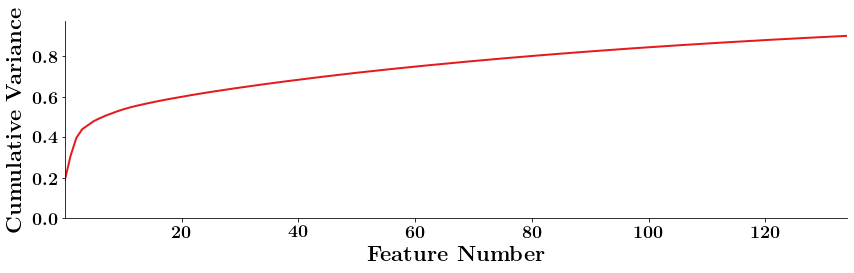

In [220]:
# combine the responses and labels to put on our 2D plot
responses = np.vstack((cumulative_variance))
labels = [r'']

# Create a 2D plot
genplt.generate_plot(np.arange(cumulative_variance.shape[0]), # X - coordinate on the plot
              responses,# Y - coordinates on the plot
              labels,# Labels for the plot legend
              'Feature Number',# X - axis label
              r'Cumulative Variance',   # Y - axis label
              filename='Test_PCA_Decomposition',   # Plot filename
              folder='figures',    # Specify the folder where the filename will be saved
              num_col=2,    # Specify the number of columns in the legend
              legend_loc='best', # Specify the location of the legend
              ymax=0.1,
              log_y=False,
              ymin=0.05,
              transparent=True,
              showplot=True,
              save_plot=True,
              template='wide',
              file_type='png'
             )



In [275]:
def plot_scores(score,delta_f,filename='scores',template='publication'):
    
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()    
        
    yi = np.arange(-0.0, score.shape[0]) + 2
    xi = (np.arange(0.0,score.shape[1]) + 2) * delta_f

    X, Y = np.meshgrid(xi, yi)

#     plt.figure(figsize=(12,4))
    ax = plt.gca()
    plt.pcolormesh(X,Y,score,cmap='cividis',norm=colors.Normalize(vmin=np.amin(score),vmax=np.amax(score)))
    cbar = plt.colorbar()
    cbar.set_label(r'\textbf{Normalized Score}', rotation=270,labelpad=20)
    plt.ylabel(r'\textbf{PCA Dimensions}', labelpad=5,fontsize=22)
    plt.xlabel(r'\textbf{PSD Bandwidth (Hz)}', labelpad=5,fontsize=22)
    
    plt.tight_layout(pad=1.2)
    plt.savefig('figures/' + filename + '.png',transparent=True)  
    plt.show()
    

def box_plot_compare(data,labels,legend,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=None,template='publication',
             xtickpad=5,showfliers=False,legend_loc='best',max_cutoff=0,min_cutoff=0,plot_type='violin'):
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()
        
    position = [i+1 for i in range(len(data))]
    tickPositions = []
    phantomLines = []
        
    for i in range(data[0].shape[1]):
        
        thisData = [data[j][:,i] for j in range(len(data))]

        bp = plt.boxplot(thisData,
                        positions=position,
                        showfliers=showfliers,
                        patch_artist=True,
                        meanline=False,
                        notch=False,
                        medianprops={'color':'black',
                                     'linewidth':2},
                        whiskerprops={'linewidth':2},
                        capprops={'linewidth':2},
                        widths=0.75)

        for counter,patch in enumerate(bp['boxes']):
            # change outline color
            patch.set(color=colors[counter], linewidth=2)
            patch.set_facecolor(colors[counter])

            if i == 0:
                line, = plt.plot([1,1],color=colors[counter])
                phantomLines.append(line)
            
        tickPositions.append(np.mean(position))    
        position = [position[i] + len(data) + 1 for i in range(len(position))]
            
    ax = plt.gca()

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    ax.set_xticks(tickPositions)
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    ax.legend(tuple(phantomLines),tuple(legend),loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
    
    [phantomLines[i].set_visible(False) for i in range(len(phantomLines))]
    
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()
    

In [276]:
[stats[0],stats[2]][0].shape

(156, 5)

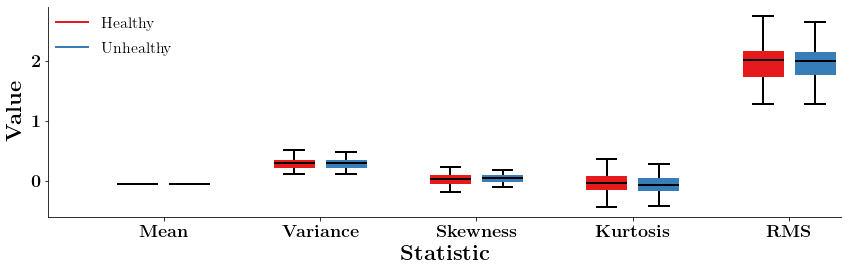

In [277]:
box_plot_compare([stats[0],stats[2]],['Mean','Variance','Skewness','Kurtosis','RMS'],['Healthy','Unhealthy'],savefig=True,filename='Time-Domain_Full-Compare',
         template='wide',xlabel='Statistic',color_order=np.zeros(6).astype(int),ylabel='Value',
         showfliers=False,legend_loc='upper left',max_cutoff=2,plot_type='box',
         log_y=False)

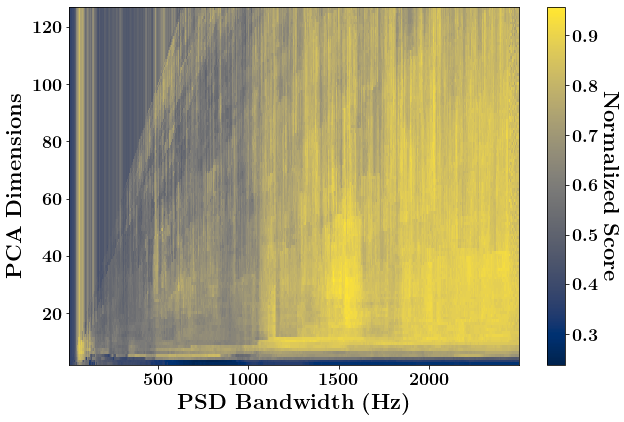

In [280]:
plot_scores(combined_score,freqs[1],filename='noDoE_Scores_Presentation',template='Presentation')

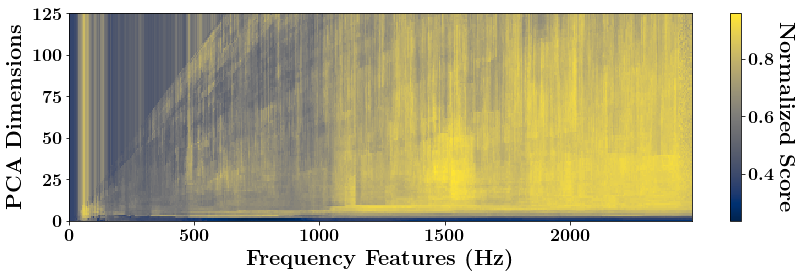

In [282]:
yi = np.arange(-0.0, valid_score.shape[0])
xi = np.arange(0.0,valid_score.shape[1])
xi = freqs[:valid_score.shape[1]]
X, Y = np.meshgrid(xi, yi)


plt.figure(figsize=(12,4))
ax = plt.gca()
plt.pcolormesh(X,Y,combined_score,cmap='cividis',norm=colors.Normalize(vmin=np.amin(combined_score),vmax=np.amax(combined_score)))
cbar = plt.colorbar()
cbar.set_label(r'\textbf{Normalized Score}', rotation=270,labelpad=20)
plt.ylabel(r'\textbf{PCA Dimensions}', labelpad=5,fontsize=22)
plt.xlabel(r'\textbf{Frequency Features (Hz)}', labelpad=5,fontsize=22)

plt.tight_layout(pad=1.2)

plt.show()

In [283]:
max_fft = best_fft
pca_components = best_pca
DoE_shape = 0
stats_shape = 0

X_train = np.hstack((XY_train[:,:max_fft],stats_train[:,:stats_shape],DoE_train[:,:DoE_shape]))
X_valid = np.hstack((XY_valid[:,:max_fft],stats_valid[:,:stats_shape],DoE_test[:,:DoE_shape]))
        
estimators = [('reduce_dim', PCA(n_components=pca_components)), ('gnb', GaussianNB())]

pipe = Pipeline(estimators)
pipe.fit(X_train,Y_train)

Y_valid_pred = pipe.predict(X_valid)
conf_matrix_valid = confusion_matrix(Y_valid, Y_valid_pred)
accuracy_valid = np.sum(np.diagonal(conf_matrix_valid)) / np.sum(conf_matrix_valid)
print(conf_matrix_valid)
print(accuracy_valid)

Y_train_pred = pipe.predict(X_train)
conf_matrix_train = confusion_matrix(Y_train, Y_train_pred)
accuracy_train = np.sum(np.diagonal(conf_matrix_train)) / np.sum(conf_matrix_train)
print(conf_matrix_train)
print(accuracy_train)

valid_stats = fit_statistics(Y_valid,Y_valid_pred)
train_stats = fit_statistics(Y_train,Y_train_pred)

print(valid_stats[-1]**2 + valid_stats[-2]**2)
print(train_stats[-1]**2 + train_stats[-2]**2)

print(valid_stats[-2],valid_stats[-1])

dump(pipe, 'data/pca_gnb.joblib') 

[[83  3]
 [ 4 61]]
0.9536423841059603
[[149   1]
 [  1 155]]
0.9934640522875817
1.830282820031701
2.0
0.9649122807017544 0.9482758620689655


['data/pca_gnb.joblib']

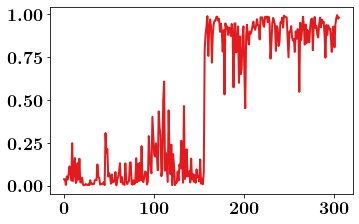

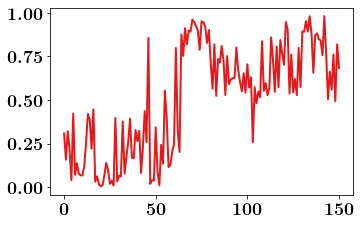

In [284]:
plt.plot(pipe.predict_proba(X_train_original[:,:max_fft + DoE_shape])[:,0])
plt.show()

plt.plot(pipe.predict_proba(X_test_original[:,:max_fft + DoE_shape])[:,0])
plt.show()

No handles with labels found to put in legend.


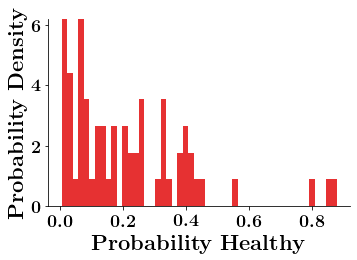

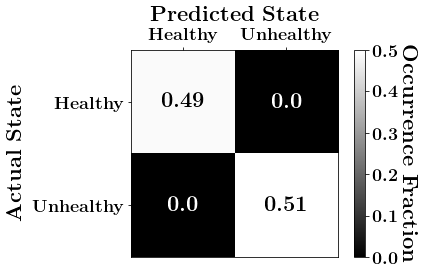

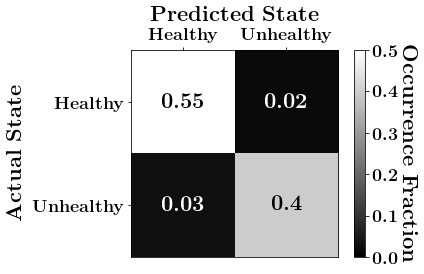

No handles with labels found to put in legend.


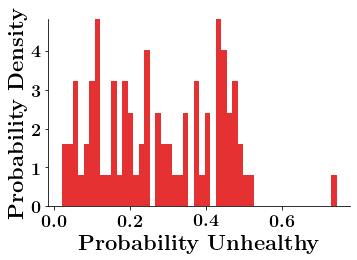

(1.0, 1.0, 1.0, 1.0, 1.0)
(0.9503284072249589, 0.9482758620689655, 0.9523809523809523, 0.9649122807017544, 0.9482758620689655)


In [285]:
# pipe.predict_proba(X_train_healthy)[:,0]

responses= np.vstack((
                       pipe.predict_proba(X_valid_healthy[:,:max_fft + DoE_shape])[:,0]))
genplt.plot_histogram(responses,[''],
               'Probability Healthy',
               'Probability Density',
               'pca_gnb_predict_healthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.0,
               num_col=1,
               nbins=50)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_valid'
                       )

responses= np.vstack((
                       pipe.predict_proba(X_valid_unhealthy[:,:max_fft + DoE_shape])[:,1]))
genplt.plot_histogram(responses,[''],
               'Probability Unhealthy',
               'Probability Density',
               'pca_gnb_predict_unhealthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.0,
               num_col=1,
               nbins=50)

print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [198]:
import numpy as np

import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization

from ML_Train.Custom_Layers import Dropout_Live
import kerastuner as kt

def build_hp_classifier(hp):
    
    mlp = Sequential()
    mlp.add(Input(shape=max_fft + DoE_shape))
    mlp.add(Flatten())
    
    for i in range(hp.Int('hidden_layers', 2, 5, step=1)):
        mlp.add(Dense(hp.Int('filters_' + str(i), 8, 256, step=8), activation='relu'))
        mlp.add(BatchNormalization())
        mlp.add(Dropout(hp.Float('dropout_rate_' + str(i), 0.0, 0.5, step=0.1)))
        
    mlp.add(Dense(2,activation='softmax'))
    
    mlp.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
        
    return mlp

In [199]:
max_fft = 256
DoE_shape = 1

X_train = np.hstack((XY_train[:,:max_fft],DoE_train[:,:DoE_shape]))
X_valid = np.hstack((XY_valid[:,:max_fft],DoE_test[:,:DoE_shape]))


tuner = kt.Hyperband(
    build_hp_classifier,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=4,
    directory='fft_classifier',
    project_name='mlp_fft_classifier')

tuner.search(X_train,np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
             validation_data=(X_valid,np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

INFO:tensorflow:Reloading Oracle from existing project fft_classifier/mlp_fft_classifier/oracle.json
INFO:tensorflow:Reloading Tuner from fft_classifier/mlp_fft_classifier/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [200]:
model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]


loss = model.fit(
            X_train,np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
            validation_data=(X_valid,np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
            epochs=40,
            verbose=1)

Y_mlp_valid_pred = model.predict(X_valid)
Y_mlp_train_pred = model.predict(X_train)

Y_mlp_train_pred = np.argmax(Y_mlp_train_pred,axis=1)
Y_mlp_valid_pred = np.argmax(Y_mlp_valid_pred,axis=1)

ValueError: Shapes (257, 240) and (321, 240) are incompatible

In [26]:
conf_matrix_valid = confusion_matrix(Y_valid, Y_mlp_valid_pred)
accuracy_valid = np.sum(np.diagonal(conf_matrix_valid)) / np.sum(conf_matrix_valid)
print(conf_matrix_valid)
print(accuracy_valid)

conf_matrix_train = confusion_matrix(Y_train, Y_mlp_train_pred)
accuracy_train = np.sum(np.diagonal(conf_matrix_train)) / np.sum(conf_matrix_train)
print(conf_matrix_train)
print(accuracy_train)


[[47 18]
 [31 55]]
0.6754966887417219
[[103  53]
 [  0 150]]
0.826797385620915


In [27]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live, Sampling

def build_classifier(
                   hp
                   ):
    inputs = Input(shape=(max_fft + DoE_shape,1))
    x = inputs
    
    for i in range(hp.Int('filters', 1, 5, step=1)):
        x = Conv1D(filters=hp.Int('filters_' + str(i), 4, 64, step=4), 
                           kernel_size=hp.Int('kernels_' + str(i), 3, 19, step=4), 
                           strides=1, 
                           activation='relu', 
                           padding='same',
                           dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float('dropout_rate_' + str(i), 0.0, 0.5, step=0.1))(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    for i in range(hp.Int('dense_layers', 1, 3, step=1)):
        x = Dense(hp.Int('dense_' + str(i), 8, 256, step=8), activation='selu')(x)

    x = Dense(2,activation='softmax')(x)
    
    cnn_classifier = Model(
                            inputs=[inputs],
                            outputs=[x])
    
    cnn_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
     
    
    return cnn_classifier


In [28]:

tuner = kt.Hyperband(
    build_classifier,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=4,
    directory='fft_classifier',
    project_name='cnn_fft_classifier')

tuner.search(X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
             validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

INFO:tensorflow:Reloading Oracle from existing project fft_classifier/cnn_fft_classifier/oracle.json
INFO:tensorflow:Reloading Tuner from fft_classifier/cnn_fft_classifier/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [29]:
model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

loss = model.fit(
            X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
#                 validation_split=0.2,
            validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
            epochs=30,
            verbose=1)



Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 10s - loss: 0.0829 - accuracy: 1.000 - 1s 5ms/sample - loss: 0.0545 - accuracy: 0.9935 - val_loss: 0.6215 - val_accuracy: 0.6291
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 1.00 - 0s 112us/sample - loss: 0.0262 - accuracy: 1.0000 - val_loss: 0.6111 - val_accuracy: 0.6026
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 1.00 - 0s 122us/sample - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.6249 - val_accuracy: 0.5232
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 1.00 - 0s 126us/sample - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.5491 - val_accuracy: 0.9007
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 1.00 - 0s 119us/sample - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.5720 - val_accuracy: 0.6291
Epoch 6/30
306

In [30]:
Y_cnn_valid_pred = model.predict(X_valid[...,np.newaxis])
Y_cnn_train_pred = model.predict(X_train[...,np.newaxis])

Y_cnn_train_pred = np.argmax(Y_cnn_train_pred,axis=1)
Y_cnn_valid_pred = np.argmax(Y_cnn_valid_pred,axis=1)

In [31]:

conf_matrix_cnn_valid = confusion_matrix(Y_valid, Y_cnn_valid_pred)
accuracy_cnn_valid = np.sum(np.diagonal(conf_matrix_cnn_valid)) / np.sum(conf_matrix_cnn_valid)
print(conf_matrix_cnn_valid)
print(accuracy_cnn_valid)

conf_matrix_cnn_train = confusion_matrix(Y_train, Y_cnn_train_pred)
accuracy_cnn_train = np.sum(np.diagonal(conf_matrix_cnn_train)) / np.sum(conf_matrix_cnn_train)
print(conf_matrix_cnn_train)
print(accuracy_cnn_train)

[[63  2]
 [29 57]]
0.7947019867549668
[[156   0]
 [  0 150]]
1.0


No handles with labels found to put in legend.


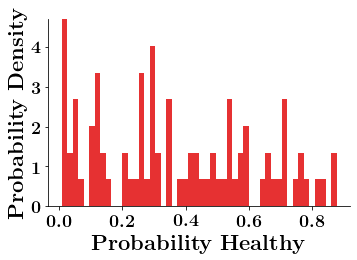

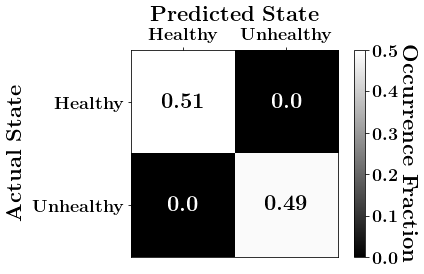

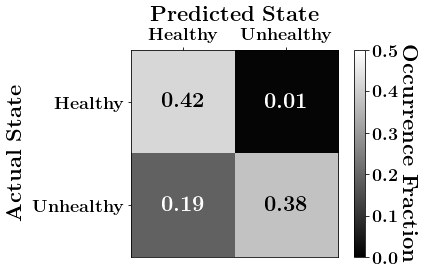

No handles with labels found to put in legend.


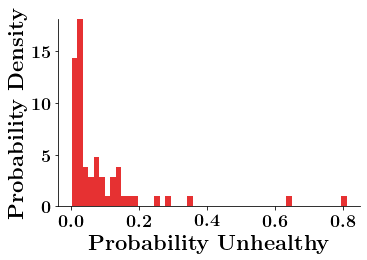

(1.0, 1.0, 1.0, 1.0, 1.0)
(0.8314417822614544, 0.6885245901639344, 0.9743589743589743, 0.9767441860465116, 0.6885245901639344)


In [51]:
# pipe.predict_proba(X_train_healthy)[:,0]

responses= np.vstack((
                       model.predict(X_valid_healthy[:,:max_fft + DoE_shape][...,np.newaxis])[:,0]))
genplt.plot_histogram(responses,[''],
               'Probability Healthy',
               'Probability Density',
               'pca_gnb_predict_healthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.0,
               num_col=1,
               nbins=50)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_cnn_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_cnn_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_valid'
                       )

responses= np.vstack((
                       model.predict(X_valid_unhealthy[:,:max_fft + DoE_shape][...,np.newaxis])[:,1]))
genplt.plot_histogram(responses,[''],
               'Probability Unhealthy',
               'Probability Density',
               'pca_gnb_predict_unhealthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.0,
               num_col=1,
               nbins=50)

print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [32]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 3D output
            if len(layer.output_shape) == 3:
                return layer.name

        # otherwise, we could not find a 3D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 3D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, inputs, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 3D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, 
                self.model.output])
        
        image = inputs

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [33]:
image = X_valid[index,...].reshape(1,max_fft + DoE_shape,1)
image.shape

NameError: name 'index' is not defined

In [52]:
np.amin(image[0])
Y_valid_pred

array([1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.])

(1, 257, 1)


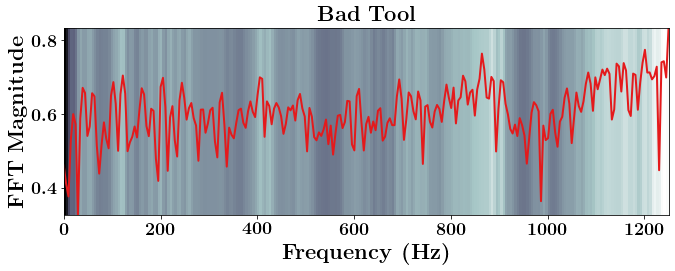

In [57]:
index = -1
image = X_train[index,:].reshape(1,max_fft + DoE_shape,1)


print(image.shape)

cam = GradCAM(model, int(Y_train_pred[index]))
heatmap = cam.compute_heatmap(image).T
heatmap = np.repeat(heatmap,2,axis=0)
# frequencyInterval = 19.53125

plt.figure(figsize=(12,4))
ax = plt.gca()

frequencyInterval = 10000/2048

xi = np.arange(-0.0, (max_fft+1) * frequencyInterval,frequencyInterval)
yi = np.linspace(np.amin(image[0]),np.amax(image[0]),2)


X, Y = np.meshgrid(xi, yi)
plt.pcolormesh(X,Y,heatmap,cmap='bone',alpha=1)
plt.plot(xi,image[0,:,:])
ax.grid(False)
plt.xlabel(r'\textbf{Frequency (Hz)}')
plt.ylabel(r'\textbf{FFT Magnitude}')
plt.title(r'\textbf{Bad Tool}',fontsize=22)
plt.savefig('figures/Grad-CAM-Bad.png',transparent=True)  

plt.show()
